# CosmoSLICS simulation testing
07/2023                                                                       

In [1]:
%matplotlib inline                                                            
%load_ext autoreload                                                          
%autoreload 2                                                                                                                                                 

In [2]:
import matplotlib.pylab as plt
import os
import copy
import numpy as np
from cs_util import cat as cs_cat

In [3]:
import sp_peaks           
print(f"sp_peaks version = {sp_peaks.__version__}")

from sp_peaks import slics

sp_peaks version = 0.0.1


In [8]:
# Set input directories

# SLICS simulations
root_directory = "/n17data/tersenov/SLICS/Cosmo_DES"
#root_directory = "."

# CFIS redshift distribution
dndz_CFIS_directory = "/n17data/mkilbing/astro/data/CFIS/v1.0/nz"

## Read SLICS catalogue

In [5]:
cat_path = f"{root_directory}/06_f/LOS3/DES_MocksCat_06_f_4_Bin3_LOS3_R19.dat"

In [6]:
# Load catalogue, all columns
dat = slics.read_catalogue(cat_path)

In [7]:
# Print column names
print(dat.dtype.names)

('RA', 'Dec', 'e1_data', 'e2_data', 'w', 'redshift_true_sim', 'gamma1_sim', 'gamma2_sim', 'kappa_sim', 'S_metacal_data')


In [9]:
# Print first line
print(dat[0])

    RA       Dec      e1_data     e2_data     w  redshift_true_sim  gamma1_sim   gamma2_sim   kappa_sim   S_metacal_data
--------- ---------- ---------- ------------ --- ----------------- ----------- ------------- ------------ --------------
9.9850721 0.83404565 -0.3871837 -0.093102939 1.0        0.81983972 0.011937537 0.00051228399 -0.010907983    -0.17440903


In [10]:
# Load only essential columns
dat_ess = slics.read_catalogue(cat_path, all_col=False)

In [13]:
print(dat_ess[0])

    RA       Dec     redshift_true_sim  gamma1_sim   gamma2_sim 
--------- ---------- ----------------- ----------- -------------
9.9850721 0.83404565        0.81983972 0.011937537 0.00051228399


## Read and combine multiple SLICS catalogues

In [41]:
# Combine all four redshift bins for given cosmo ID, line of sight, and tile number
dat_comb = slics.read_multiple_catalogues(
    root_directory,
    cosmo_id="06_f",
    zbins=None,
    lsos=[2],
    tiles=[5],
    combine="add",
    verbose=True,
)

Reading catalogue 06_f/LOS2/DES_MocksCat_06_f_4_Bin1_LOS2_R5.dat...
Reading catalogue 06_f/LOS2/DES_MocksCat_06_f_4_Bin2_LOS2_R5.dat...
Reading catalogue 06_f/LOS2/DES_MocksCat_06_f_4_Bin3_LOS2_R5.dat...
Reading catalogue 06_f/LOS2/DES_MocksCat_06_f_4_Bin4_LOS2_R5.dat...


In [42]:
print(f"Number of galaxies = {len(dat_comb)}")
n_gal = slics.get_number_density(dat_comb)
print(f"Number density = {n_gal:.2f} arcmin^{{-2}}")

Number of galaxies = 1236929
Number density = 3.56 arcmin^{-2}


### Resample SLICS to match exteral dn/dz

In [43]:
# Set CFIS redshift distribution (blind version "A", ShapePipe)
dndz_CFIS_path = f"{dndz_CFIS_directory}/dndz_SP_A.txt"

In [44]:
# Test resampling. Compare redshift distributions

# External (CFIS) redshift histogram
z_centers_ext, dndz_ext, z_edges_ext = cs_cat.read_dndz(dndz_CFIS_path)

# Original SLICS redshift histogram
dndz_slics, _ = np.histogram(dat_comb["redshift_true_sim"], bins=z_edges_ext)

# Original SLICS normalised redshift histogram
dndz_slics_norm, _ = np.histogram(dat_comb["redshift_true_sim"], bins=z_edges_ext, density=True)

In [45]:
# Set the number of objects to resample.
# Has to be smaller than number of input objects.
n_goal = len(dat_comb) / 2

In [46]:
# Resample
slics.resample_z(dat_comb, dndz_CFIS_path, n_goal, z_max=1.8, verbose=True)

dropping 622883 to match nofz


In [47]:
# Testing

# Resampled SLICS redshift histogram
dndz_resampled, _ = np.histogram(dat_comb["redshift_true_sim"], bins=z_edges_ext)

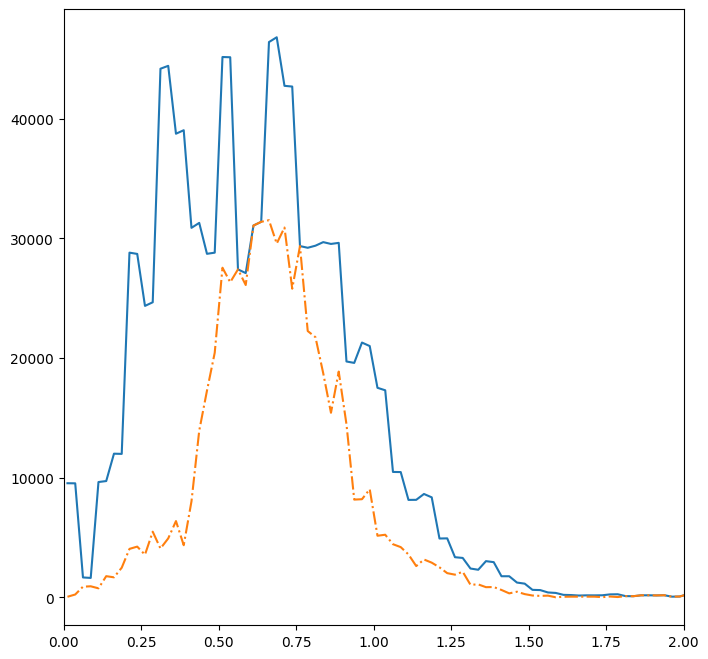

In [48]:
# Testing: resampled numbers are never higher than original ones
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(
    z_centers_ext, dndz_slics, '-',
    z_centers_ext, dndz_resampled, '-.',
)
ax.set_xlim([0, 2])
plt.savefig("dndz_slics_res.pdf")

/tmp/ipykernel_31672/1314214541.py:6: RuntimeWarning: invalid value encountered in divide
  z_centers_ext, dndz_resampled / dndz_slics, '-',


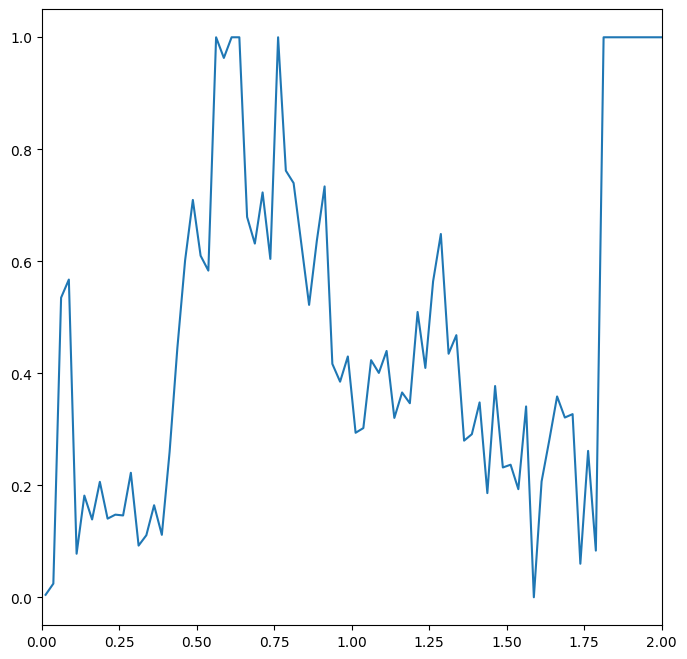

In [49]:
# Testing: ratio of resampled to original numbers are never larger than unity

fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(
    z_centers_ext, dndz_resampled / dndz_slics, '-',
)
ax.set_xlim([0, 2])
plt.savefig("dndz_slics_res_ratio.pdf")

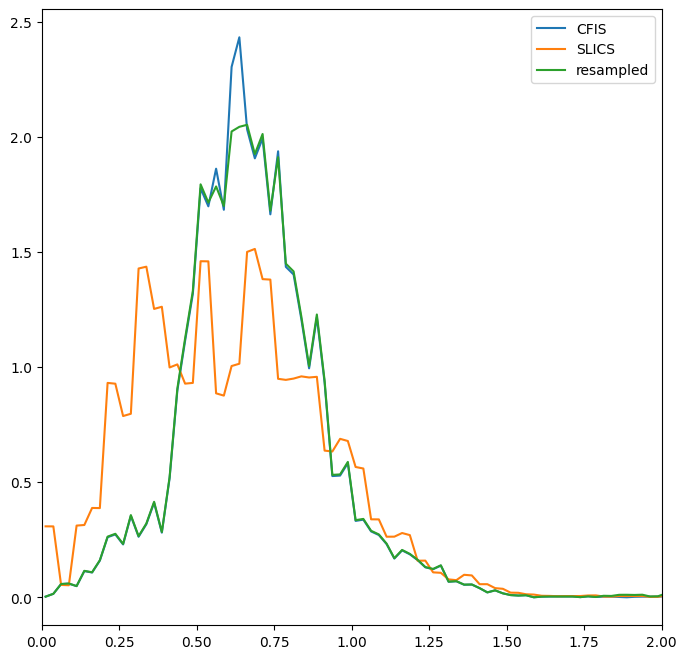

In [50]:
# Resampled SLICS redshift histogram
dndz_resampled_norm, _ = np.histogram(dat_comb["redshift_true_sim"], bins=z_edges_ext, density=True)

# Testing: resampled dndz follows external dndz

fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(z_centers_ext, dndz_ext, '-', label='CFIS')
ax.plot(z_centers_ext, dndz_slics_norm, '-', label='SLICS')
ax.plot(z_centers_ext, dndz_resampled_norm, '-', label='resampled')
ax.set_xlim([0, 2])
_ = ax.legend()
plt.savefig("dndz_CFIS_slics_res.pdf")